# Application: using Piven on yearpredictionMSD dataset

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from piven.regressors import build_keras_piven
from piven.loss import piven_loss
from piven.metrics import mpiw, picp
from piven.transformers import PivenTransformedTargetRegressor
from piven.wrappers import PivenModelWrapper
from piven.metrics import coverage, pi_distance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from sklearn.compose import TransformedTargetRegressor

dpath = Path("data/YearPredictionMSD.txt")

In [2]:
records = []
with dpath.open("r") as infile:
    for line in infile.readlines():
        line_split = line.replace("\n", "").split(",")
        year = int(line_split[0])
        inputs = [*map(lambda x: float(x), line_split[1:])]
        records.append([year] + inputs)

In [3]:
df = pd.DataFrame(records)

In [4]:
df.columns = ["year"] + [f"feature_{i}" for i in range(1, df.shape[-1])]

In [5]:
df.head()

,year,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [6]:
df.shape

(515345, 91)

In [7]:
# As per instructions https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD
train_samples = 463715
train = df.iloc[:train_samples,:]
test = df.iloc[train_samples:, :]

train_y = train.year.values
test_y = test.year.values
train_x = train.iloc[:, 1:].values
test_x = test.iloc[:, 1:].values

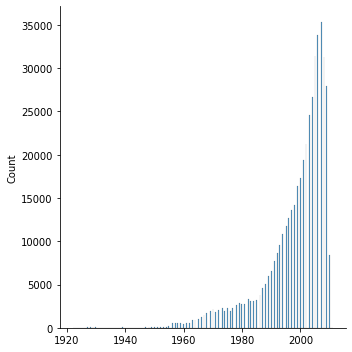

In [8]:
sns.displot(train_y)
plt.show()

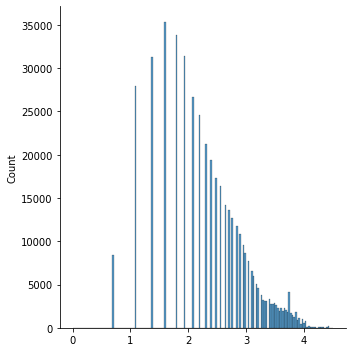

In [9]:
# Transform outcome variable (left-skewed)

max_out_train = np.max(train_y)
train_y_reflected = np.log(1 + max_out_train - train_y)
test_y_reflected = np.log(1 + max_out_train - test_y)

sns.displot(train_y_reflected)
plt.show()

In [11]:
# Make build function for the model wrapper
def piven_model(input_dim, dense_units, dropout_rate):
    model = build_keras_piven(input_dim=input_dim,
                             dense_units=dense_units,
                             dropout_rate=dropout_rate,
                             activation="relu",
                             bias_init_low=-3,
                             bias_init_high=3)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                  loss=piven_loss(10.0, 100.0, 0.05),
                  metrics=[picp, mpiw])
    return model

In [12]:
# Set up the model using the MLP that comes with piven.py
model = PivenModelWrapper(build_fn=piven_model, 
                          input_dim=train_x.shape[-1], 
                          dense_units=(64,32), 
                          dropout_rate=(0.0,0.0))

In [13]:
# Put model in pipeline
pipeline = Pipeline([
    ("preprocess", StandardScaler()),
    ("model", model)
])

In [14]:
# Add to transformed target regressor
model_ttr = PivenTransformedTargetRegressor(
    regressor=pipeline,
    transformer=StandardScaler()
)

In [15]:
# Fit
h = model_ttr.fit(train_x, train_y_reflected, model__epochs=15, model__validation_split=0.2, model__batch_size=64)

Epoch 1/15
5797/5797 [==============================] - 7s 1ms/step - loss: 9.9599 - picp: 0.8119 - mpiw: 3.9774 - val_loss: 5.5102 - val_picp: 0.9027 - val_mpiw: 3.7637
Epoch 2/15
5797/5797 [==============================] - 5s 915us/step - loss: 5.0064 - picp: 0.9024 - mpiw: 3.6076 - val_loss: 4.9862 - val_picp: 0.9079 - val_mpiw: 3.4605
Epoch 3/15
5797/5797 [==============================] - 5s 928us/step - loss: 4.5809 - picp: 0.9042 - mpiw: 3.3367 - val_loss: 4.8716 - val_picp: 0.8919 - val_mpiw: 3.1575
Epoch 4/15
5797/5797 [==============================] - 6s 956us/step - loss: 4.3467 - picp: 0.9047 - mpiw: 3.1919 - val_loss: 4.6915 - val_picp: 0.8970 - val_mpiw: 3.0985
Epoch 5/15
5797/5797 [==============================] - 6s 964us/step - loss: 4.2272 - picp: 0.9056 - mpiw: 3.1127 - val_loss: 4.5877 - val_picp: 0.8990 - val_mpiw: 3.0420
Epoch 6/15
5797/5797 [==============================] - 6s 974us/step - loss: 4.1295 - picp: 0.9056 - mpiw: 3.0445 - val_loss: 4.5428 - val_pi

In [16]:
ypred, y_pi_low, y_pi_high = model_ttr.predict(test_x, return_prediction_intervals=True)

In [17]:
# Back-transform the predictions and PIs
def back_transform(x, max_train):
    xexp = np.exp(x)
    return max_train + 1 - xexp
ypred = back_transform(ypred, max_out_train)
# Need to reverse the bounds
y_pi_low_t = back_transform(y_pi_high, max_out_train)
y_pi_high_t = back_transform(y_pi_low, max_out_train)

In [18]:
coverage(test_y, y_pi_low_t, y_pi_high_t)

0.8990122022080186

In [19]:
pi_distance(y_pi_low_t, y_pi_high_t)

28.344301

In [20]:
df_res = pd.DataFrame({
    "true":test_y,
    "pred":ypred,
    "pi_low":y_pi_low_t,
    "pi_high":y_pi_high_t
})

In [21]:
print(mae(test_y, ypred))
print(np.sqrt(mse(test_y, ypred)))

6.243799371920698
9.58067081591155


In [22]:
col_out = (y_pi_low_t <= test_y) & (test_y <= y_pi_high_t)
colmap = np.array(["green" if cov else "red" for cov in col_out])

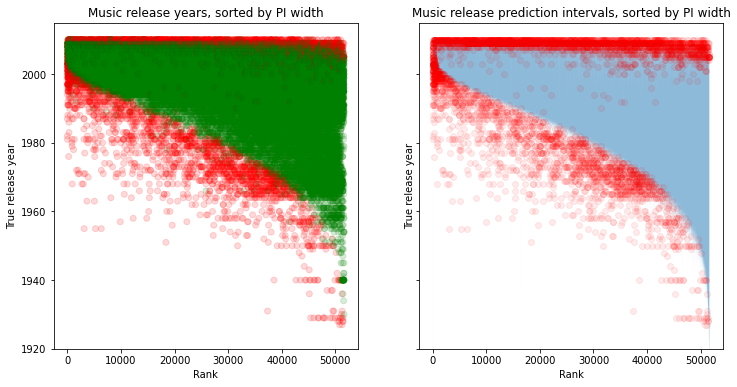

In [31]:
pi_width_sorted_idx = np.argsort(y_pi_high_t - y_pi_low_t)
test_y_sorted = test_y[pi_width_sorted_idx]
colmap_sorted = colmap[pi_width_sorted_idx]

fig, ax = plt.subplots(1,2, figsize=(12,6), sharey=True, sharex=True)
ax[0].scatter(range(test_y.shape[0]), test_y_sorted, c=colmap_sorted,alpha=0.15)
ax[0].set_ylim(1920, 2015)
ax[0].set_title("Music release years, sorted by PI width")
ax[0].set_xlabel("Rank")
ax[0].set_ylabel("True release year")

pred_wrong = test_y_sorted[colmap_sorted == "red"]
year_wrong = np.array([*range(test_y.shape[0])])[colmap_sorted == "red"]
ax[1].fill_between(
    range(test_y.shape[0]),
    y_pi_low_t[pi_width_sorted_idx],
    y_pi_high_t[pi_width_sorted_idx],
    alpha=0.5
)
ax[1].scatter(year_wrong, pred_wrong, c="r", alpha=0.08)
ax[1].set_ylim(1920, 2015)
ax[1].set_title("Music release prediction intervals, sorted by PI width")
ax[1].set_xlabel("Rank")
ax[1].set_ylabel("True release year")

plt.show()

In [24]:
outliers = df_res[df_res.true < 1960]
coverage(outliers.true, outliers.pi_low, outliers.pi_high)

outliers.head(10)

/opt/anaconda3/envs/pivenregressor/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


,true,pred,pi_low,pi_high
70,1940,1997.097168,1962.806274,2007.109375
72,1940,1997.846802,1964.455322,2007.436768
73,1940,1997.160767,1958.965088,2007.431885
922,1945,1996.548340,1941.951538,2007.925293
923,1945,1978.729492,1910.802124,2001.495728
924,1945,1988.329712,1933.350220,2005.128174
1006,1959,1996.371216,1946.882202,2007.097412
1009,1959,1995.043213,1949.228394,2007.202393
1010,1959,1998.354126,1969.526733,2007.842407
1011,1959,2001.729492,1974.028442,2009.317627


In [25]:
pi_distance(outliers.pi_low, outliers.pi_high)

52.654163

## With a regular MLP

In [26]:
model = build_keras_piven(input_dim=train_x.shape[-1],
                         dense_units=(64, 32),
                         dropout_rate=(0.1, 0.1),
                         activation="relu",
                         bias_init_low=-3,
                         bias_init_high=3)

In [29]:
def mlp_model(input_dim):    
    i = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(
        64,
        activation="relu",
    )(i)
    x = tf.keras.layers.Dense(
        32,
        activation="relu",
    )(x)
    o = tf.keras.layers.Dense(
        1,
        activation="relu",
    )(x)
    model = tf.keras.models.Model(inputs=i, outputs=[o], name="MLP")
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                  loss="mse")
    return model
mod = tf.keras.wrappers.scikit_learn.KerasRegressor(
    build_fn=mlp_model,
    input_dim=train_x.shape[-1]
)
pipeline = Pipeline([
    ("preprocess", StandardScaler()),
    ("model", mod)
])
mod_ttr = TransformedTargetRegressor(
    regressor=pipeline,
    transformer=StandardScaler()
)

In [30]:
mod_ttr.fit(train_x, train_y, model__epochs=15, model__validation_split=0.2, model__batch_size=64)

Epoch 1/15
5797/5797 [==============================] - 4s 696us/step - loss: 0.9592 - val_loss: 0.9149
Epoch 2/15
5797/5797 [==============================] - 4s 693us/step - loss: 0.8934 - val_loss: 0.9032
Epoch 3/15
5797/5797 [==============================] - 4s 684us/step - loss: 0.8782 - val_loss: 0.8981
Epoch 4/15
5797/5797 [==============================] - 4s 700us/step - loss: 0.8810 - val_loss: 0.8953
Epoch 5/15
5797/5797 [==============================] - 4s 689us/step - loss: 0.8805 - val_loss: 0.8932
Epoch 6/15
5797/5797 [==============================] - 4s 687us/step - loss: 0.8733 - val_loss: 0.8920
Epoch 7/15
5797/5797 [==============================] - 4s 683us/step - loss: 0.8692 - val_loss: 0.8904
Epoch 8/15
5797/5797 [==============================] - 4s 705us/step - loss: 0.8644 - val_loss: 0.8894
Epoch 9/15
5797/5797 [==============================] - 4s 729us/step - loss: 0.8632 - val_loss: 0.8893
Epoch 10/15
5797/5797 [==============================] - 4s 694u

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocess',
                                                      StandardScaler()),
                                                     ('model',
                                                      <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f99480ecb10>)]),
                           transformer=StandardScaler())

In [ ]:
ypred_mlp = model_ttr.predict(test_x)
ypred_mlp = back_transform(ypred_mlp, max_out_train)

In [ ]:
print(mae(test_y, ypred_mlp))
print(np.sqrt(mse(test_y, ypred_mlp)))

In [ ]:
plt.scatter(ypred, ypred_mlp)
plt.xlim(1960, 2015)
plt.ylim(1960, 2015)
plt.xlabel("Predictions, PIVEN")
plt.ylabel("Predictions, MLP")
plt.show()

In [32]:
plt.scatter(ypred, ypred_mlp)
plt.xlim(1960, 2015)
plt.ylim(1960, 2015)
plt.xlabel("Predictions, PIVEN")
plt.ylabel("Predictions, MLP")
plt.show()

In [33]:
print(mae(test_y, ypred_mlp))
print(np.sqrt(mse(test_y, ypred_mlp)))

6.243799371920698
9.58067081591155


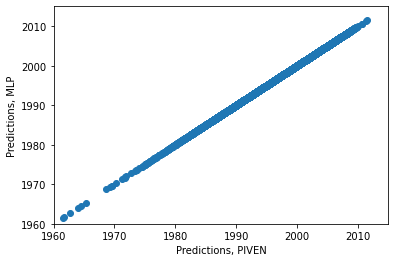

In [34]:
plt.scatter(ypred, ypred_mlp)
plt.xlim(1960, 2015)
plt.ylim(1960, 2015)
plt.xlabel("Predictions, PIVEN")
plt.ylabel("Predictions, MLP")
plt.show()